
[Aşama 1/3] Kaydedilmiş modeller bulunamadı. Optimizasyon ve eğitim başlıyor...

PCA sonrası yeni öznitelik boyutu: 2297
Hiper-parametre optimizasyonu için 7366 adet alt örneklem kullanılacak.

>>> SVM için hızlı optimizasyon başlıyor...
Fitting 2 folds for each of 6 candidates, totalling 12 fits
En iyi SVM parametreleri: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
En iyi SVM skoru (alt örneklemde): 0.8477

>>> MLP için hızlı optimizasyon başlıyor...
Fitting 2 folds for each of 2 candidates, totalling 4 fits
En iyi MLP parametreleri: {'alpha': 0.01, 'hidden_layer_sizes': (100,)}
En iyi MLP skoru (alt örneklemde): 0.7911

>>> XGBoost için hızlı optimizasyon başlıyor...
Fitting 2 folds for each of 4 candidates, totalling 8 fits
En iyi XGBoost parametreleri: {'learning_rate': 0.1, 'n_estimators': 200}
En iyi XGBoost skoru (alt örneklemde): 0.8012

--- Model (SVM) TÜM Eğitim Verisiyle Son Kez Eğitiliyor ---

--- MODEL (SVM) DEĞERLENDİRME RAPORU ---
              precision    recall  f1-sc

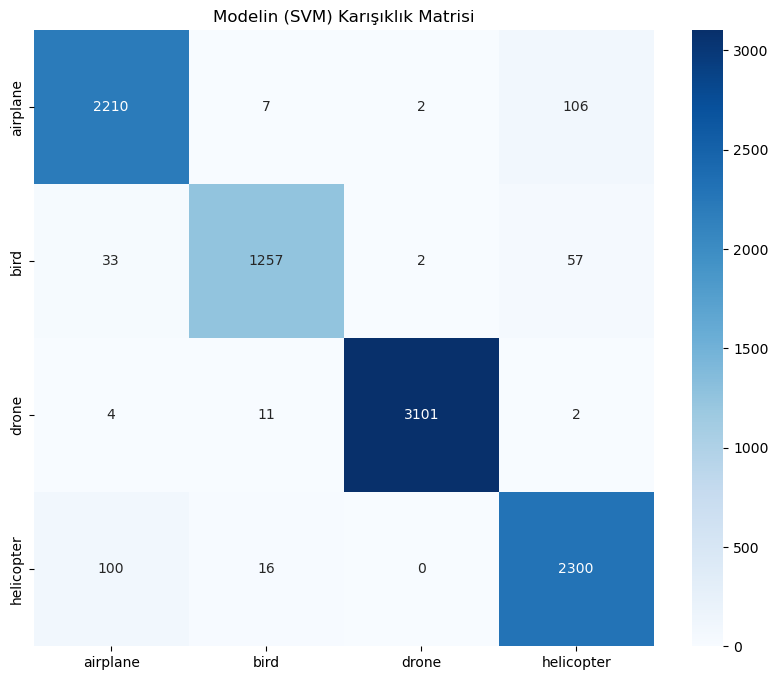


--- Model (MLP) TÜM Eğitim Verisiyle Son Kez Eğitiliyor ---

--- MODEL (MLP) DEĞERLENDİRME RAPORU ---
              precision    recall  f1-score   support

    airplane       0.91      0.91      0.91      2325
        bird       0.93      0.90      0.91      1349
       drone       0.99      0.99      0.99      3118
  helicopter       0.89      0.91      0.90      2416

    accuracy                           0.94      9208
   macro avg       0.93      0.93      0.93      9208
weighted avg       0.94      0.94      0.94      9208



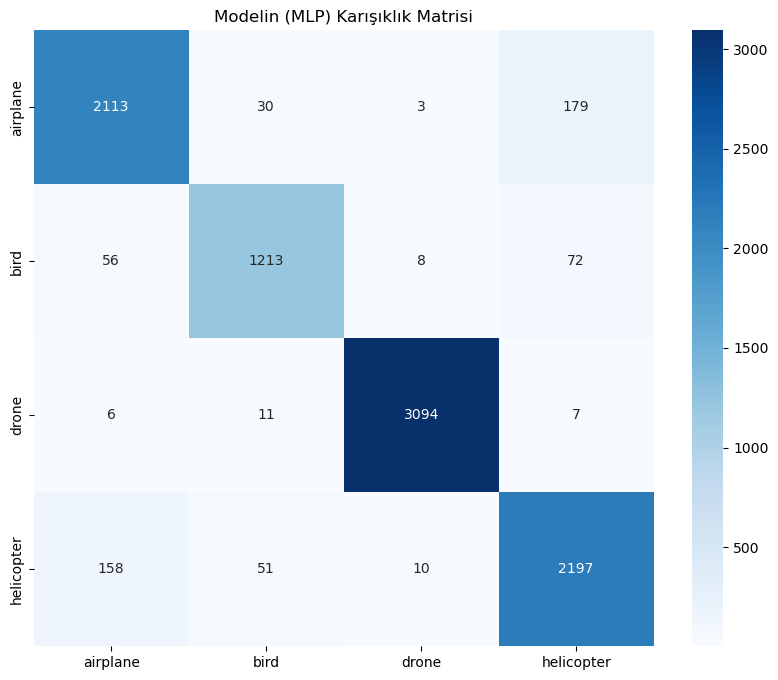


--- Model (XGBoost) TÜM Eğitim Verisiyle Son Kez Eğitiliyor ---

--- MODEL (XGBoost) DEĞERLENDİRME RAPORU ---
              precision    recall  f1-score   support

    airplane       0.85      0.87      0.86      2325
        bird       0.95      0.82      0.88      1349
       drone       1.00      0.98      0.99      3118
  helicopter       0.82      0.89      0.85      2416

    accuracy                           0.91      9208
   macro avg       0.91      0.89      0.90      9208
weighted avg       0.91      0.91      0.91      9208



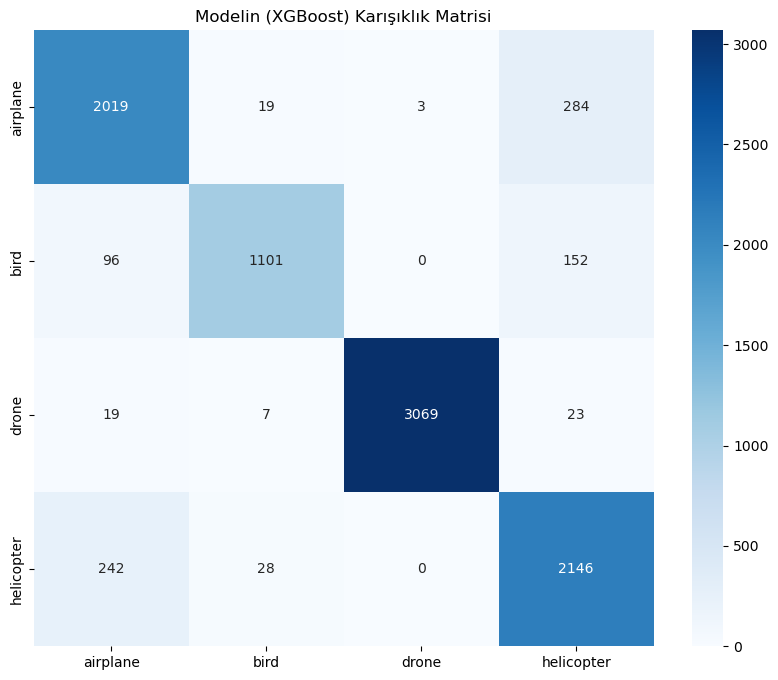

Tüm modeller ve yardımcılar 'all_trained_models.pkl' dosyasına kaydedildi.

[Aşama 2/3] Görüntü piramidi ve kaydırmalı pencere ile nesne tespiti başlıyor...
Piramit Katmanı 1, Ölçek: 1.00, Boyut: (1024, 1024)


Katman 1 taranıyor: 361it [00:48,  7.41it/s]


Piramit Katmanı 2, Ölçek: 1.50, Boyut: (682, 682)


Katman 2 taranıyor: 144it [00:19,  7.43it/s]


Piramit Katmanı 3, Ölçek: 2.26, Boyut: (454, 454)


Katman 3 taranıyor: 49it [00:06,  7.25it/s]


Piramit Katmanı 4, Ölçek: 3.39, Boyut: (302, 302)


Katman 4 taranıyor: 16it [00:02,  7.30it/s]


Piramit Katmanı 5, Ölçek: 5.09, Boyut: (201, 201)


Katman 5 taranıyor: 4it [00:00,  7.44it/s]


Piramit Katmanı 6, Ölçek: 7.64, Boyut: (134, 134)


Katman 6 taranıyor: 1it [00:00,  7.57it/s]


Toplam 1227 adet potansiyel nesne tespit edildi.

[Aşama 3/3] Sonuçlar filtreleniyor ve görselleştiriliyor...
Filtreleme sonrası 116 adet nesne kaldı.


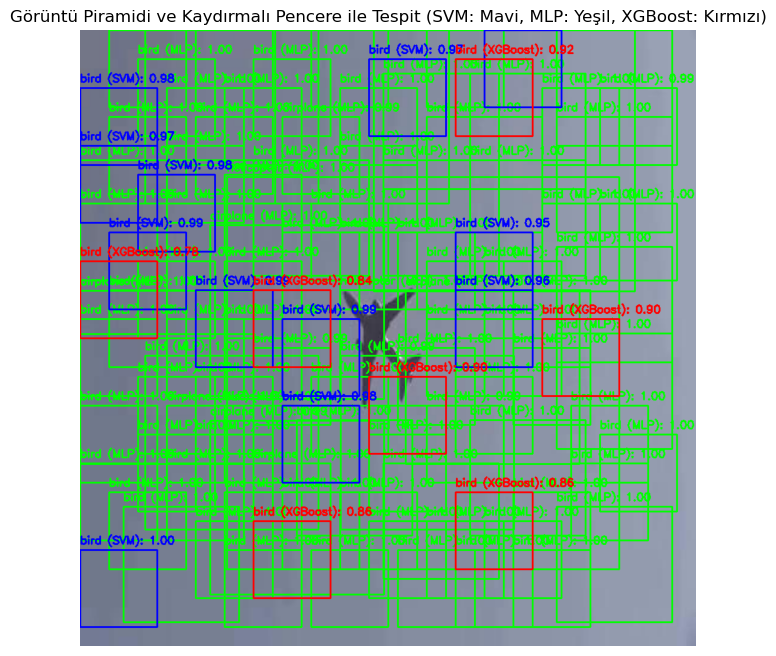

In [1]:
# Gerekli kütüphaneleri projemize dahil ediyoruz
import joblib
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

# --- Gerekli Dosyaların ve Değişkenlerin Tanımlanması ---
HOG_FEATURES_FILE = 'hog_color_augmented_features_4class.pkl'
TEST_IMAGE_PATH = "test_goruntusu.jpg"
ALL_MODELS_FILE = 'all_trained_models.pkl'

# =================================================================================
### DEĞİŞİKLİK / DÜZELTME ###: YARDIMCI FONKSİYONLAR BÖLÜMÜ
# Tüm yardımcı fonksiyonlar okunabilirlik için script'in başında toplanmıştır.
# =================================================================================

BINS = 8 # ÖNEMLİ: Bu değer, öznitelik çıkarma script'indeki değerle aynı olmalıdır!

def extract_color_histogram(image, bins=(BINS, BINS, BINS)):
    """Görüntünün 3D HSV renk histogramını çıkarır ve düzleştirir."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def sliding_window(image, step_size, window_size):
    """Görüntü üzerinde belirli bir adım sıklığıyla pencere kaydırır."""
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def pyramid(image, scale=1.5, minSize=(128, 128)):
    """Görüntüden farklı ölçeklerde bir piramit oluşturur."""
    yield image
    while True:
        w = int(image.shape[1] / scale)
        image = cv2.resize(image, (w, int(image.shape[0] * (w / float(image.shape[1])))))
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image

# =================================================================================
# FAZ A: MODEL SEÇİMİ VE EĞİTİMİ
# =================================================================================

if not os.path.exists(ALL_MODELS_FILE):
    print(f"\n[Aşama 1/3] Kaydedilmiş modeller bulunamadı. Optimizasyon ve eğitim başlıyor...")
    
    # --- 1. Veri Yükleme ve Hazırlama ---
    data = joblib.load(HOG_FEATURES_FILE)
    X, y_text = data['features'], data['labels']
    le = LabelEncoder()
    y = le.fit_transform(y_text)
    class_names = le.classes_
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print(f"\nPCA sonrası yeni öznitelik boyutu: {pca.n_components_}")

    # --- 2. Hızlı Hiper-parametre Optimizasyonu ---
    num_subset = int(len(X_train_pca) * 0.20)
    X_train_subset = X_train_pca[:num_subset]
    y_train_subset = y_train[:num_subset]
    print(f"Hiper-parametre optimizasyonu için {num_subset} adet alt örneklem kullanılacak.")
    
    models_to_test = {
        'SVM': (SVC(probability=True, random_state=42), {'C': [1, 10, 50], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}),
        'MLP': (MLPClassifier(max_iter=500, random_state=42), {'hidden_layer_sizes': [(100,)], 'alpha': [0.001, 0.01]}),
        'XGBoost': (XGBClassifier(eval_metric='mlogloss', random_state=42), {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05]})
    }
    
    best_estimators = {}
    
    for name, (model, params) in models_to_test.items():
        print(f"\n>>> {name} için hızlı optimizasyon başlıyor...")
        grid_search = GridSearchCV(model, params, cv=2, n_jobs=-1, verbose=1)
        grid_search.fit(X_train_subset, y_train_subset)
        
        best_estimators[name] = grid_search.best_estimator_
        print(f"En iyi {name} parametreleri: {grid_search.best_params_}")
        print(f"En iyi {name} skoru (alt örneklemde): {grid_search.best_score_:.4f}")

    # --- 3. Tüm Modellerin Final Eğitimi ve Değerlendirilmesi ---
    trained_models = {}
    for name, best_model in best_estimators.items():
        print(f"\n--- Model ({name}) TÜM Eğitim Verisiyle Son Kez Eğitiliyor ---")
        best_model.fit(X_train_pca, y_train)
        trained_models[name] = best_model
        
        print(f"\n--- MODEL ({name}) DEĞERLENDİRME RAPORU ---")
        y_pred = best_model.predict(X_test_pca)
        print(classification_report(y_test, y_pred, target_names=class_names))
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Modelin ({name}) Karışıklık Matrisi')
        plt.show()

    joblib.dump({
        'models': trained_models, 'scaler': scaler, 'pca': pca, 
        'le': le, 'class_names': class_names
    }, ALL_MODELS_FILE)
    print(f"Tüm modeller ve yardımcılar '{ALL_MODELS_FILE}' dosyasına kaydedildi.")

else:
    print(f"\n[Aşama 1/3] Kaydedilmiş '{ALL_MODELS_FILE}' dosyası bulundu. Modeller doğrudan yükleniyor.")
    # --- Modelleri Yükleme ---
    saved_data = joblib.load(ALL_MODELS_FILE)
    trained_models, scaler, pca, le, class_names = saved_data['models'], saved_data['scaler'], saved_data['pca'], saved_data['le'], saved_data['class_names']


# =================================================================================
# FAZ B: GÖRÜNTÜ PİRAMİDİ VE KAYDIRMALI PENCERE İLE GÖRSEL TEST
# =================================================================================
print("\n[Aşama 2/3] Görüntü piramidi ve kaydırmalı pencere ile nesne tespiti başlıyor...")

(winW, winH) = (128, 128) 
### DEĞİŞİKLİK / DÜZELTME ###: HIZ OPTİMİZASYONU
# Adım sıklığı artırılarak taranan pencere sayısı azaltıldı.
# Daha fazla hız için bu değeri 64 yapabilirsin.
step_size = 48
### BİTTİ ###

image = cv2.imread(TEST_IMAGE_PATH)
clone = image.copy()
detections = []

# HOG parametreleri
PIXELS_PER_CELL = (8, 8)
CELLS_PER_BLOCK = (2, 2)
ORIENTATIONS = 9

for i, resized in enumerate(pyramid(image, scale=1.5)):
    scale_factor = image.shape[1] / float(resized.shape[1])
    print(f"Piramit Katmanı {i+1}, Ölçek: {scale_factor:.2f}, Boyut: {resized.shape[:2]}")
    
    for (x, y, window) in tqdm(sliding_window(resized, step_size=step_size, window_size=(winW, winH)), desc=f"Katman {i+1} taranıyor"):
        if window.shape[0] != winH or window.shape[1] != winW: continue

        ### DEĞİŞİKLİK / DÜZELTME ###: VALUE_ERROR DÜZELTMESİ
        # Test sırasında da eğitimdeki gibi BİRLEŞİK öznitelik çıkarılmalıdır.
        
        # 1. Renk ve Gri Görüntüleri Hazırla
        color_window = window
        gray_window = cv2.cvtColor(color_window, cv2.COLOR_BGR2GRAY)
        
        # 2. HOG Özniteliklerini Çıkar
        hog_features = hog(gray_window, orientations=ORIENTATIONS,
                           pixels_per_cell=PIXELS_PER_CELL,
                           cells_per_block=CELLS_PER_BLOCK,
                           block_norm='L2-Hys')

        # 3. Renk Histogramı Özniteliklerini Çıkar
        color_features = extract_color_histogram(color_window)
        
        # 4. İki özellik vektörünü birleştir
        combined_features = np.concatenate([hog_features, color_features])
        
        # Scaler ve PCA'ya artık doğru boyutta (8612) veri gönderiliyor
        features_scaled = scaler.transform([combined_features])
        features_pca = pca.transform(features_scaled)
        ### BİTTİ ###

        for model_name, model in trained_models.items():
            if model_name == 'XGBoost':
                confidence_threshold = 0.75
            elif model_name == 'MLP':
                 confidence_threshold = 0.98
            else: # SVM
                confidence_threshold = 0.95 

            pred_proba = model.predict_proba(features_pca)[0]
            predicted_class_index = np.argmax(pred_proba)
            max_proba = pred_proba[predicted_class_index]
            
            if max_proba > confidence_threshold: 
                class_label = le.inverse_transform([predicted_class_index])[0]
                if class_label in ['bird', 'drone', 'airplane', 'helicopter']:
                    startX, startY = int(x * scale_factor), int(y * scale_factor)
                    endX, endY = int((x + winW) * scale_factor), int((y + winH) * scale_factor)
                    box = (startX, startY, endX, endY)
                    detections.append((box, max_proba, class_label, model_name)) 

print(f"Toplam {len(detections)} adet potansiyel nesne tespit edildi.")

# =================================================================================
# FAZ C: SONUÇLARIN GÖRSELLEŞTİRİLMESİ
# =================================================================================
# Bu bölümde herhangi bir değişiklik gerekmemektedir.

print("\n[Aşama 3/3] Sonuçlar filtreleniyor ve görselleştiriliyor...")

final_detections = []
detections.sort(key=lambda d: d[1], reverse=True) 
while len(detections) > 0:
    best_detection = detections.pop(0)
    final_detections.append(best_detection)
    (box1, _, _, _) = best_detection
    remaining_detections = []
    for other_detection in detections:
        (box2, _, _, _) = other_detection
        (x1_a, y1_a, x2_a, y2_a) = box1
        (x1_b, y1_b, x2_b, y2_b) = box2
        xA, yA = max(x1_a, x1_b), max(y1_a, y1_b)
        xB, yB = min(x2_a, x2_b), min(y2_a, y2_b)
        interArea = max(0, xB - xA) * max(0, yB - yA)
        if interArea == 0:
            remaining_detections.append(other_detection)
            continue
        boxAArea = (x2_a - x1_a) * (y2_a - y1_a)
        boxBArea = (x2_b - x1_b) * (y2_b - y1_b)
        iou = interArea / float(boxAArea + boxBArea - interArea)
        if iou < 0.3: 
            remaining_detections.append(other_detection)
    detections = remaining_detections

print(f"Filtreleme sonrası {len(final_detections)} adet nesne kaldı.")

model_colors = {'SVM': (255, 0, 0), 'MLP': (0, 255, 0), 'XGBoost': (0, 0, 255)}

for (box, proba, label, model_name) in final_detections:
    (startX, startY, endX, endY) = box
    color = model_colors.get(model_name, (255, 255, 255)) 
    cv2.rectangle(clone, (startX, startY), (endX, endY), color, 2)
    label_text = f"{label} ({model_name}): {proba:.2f}"
    cv2.putText(clone, label_text, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.title("Görüntü Piramidi ve Kaydırmalı Pencere ile Tespit (SVM: Mavi, MLP: Yeşil, XGBoost: Kırmızı)")
plt.axis('off')
plt.show()

